In [1]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetLarge, NASNetMobile

Using TensorFlow backend.


In [2]:
import utils as _utils
from vis.utils import utils

In [3]:
class_list_file = "./checkpoints/ResNet50_dataset_w_3class_class_list.txt"
class_list = _utils.load_class_list(class_list_file)

In [4]:
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
FC_LAYERS = [1024, 1024]
TRAIN_DIR = "dataset_w_3class/train/"
VAL_DIR = "dataset_w_3class/val/"
TEST_DIR = "dataset_w_3class/test/"

In [5]:
# Hide warnings on Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
finetune_model = _utils.build_finetune_model(base_model, dropout=0.5, fc_layers=FC_LAYERS, num_classes=len(class_list))
finetune_model.load_weights("./checkpoints/ResNet50_model_weights.h5")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

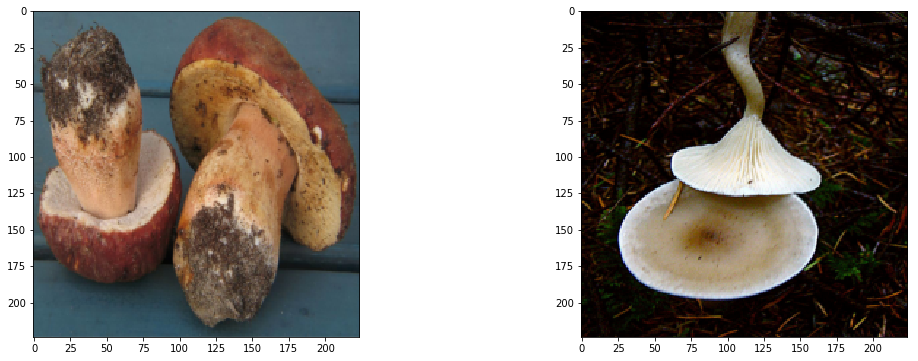

In [9]:
from vis.visualization import visualize_activation
from keras import activations
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img("./dataset_w_3class/test/edible/e_Boletus pinophilus_21.jpg", target_size=(224,224))
img2 = utils.load_img("./dataset_w_3class/test/inedible/i_Clitocybe gibba_12.jpg", target_size=(224,224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

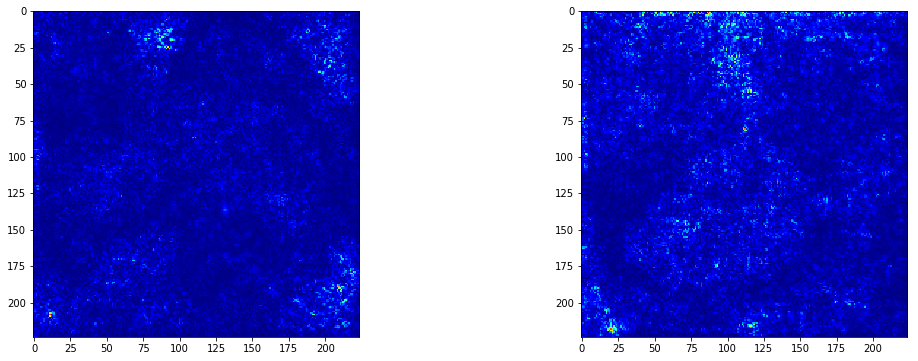

In [16]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(finetune_model, 'dense_2')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):
    grads = visualize_saliency(finetune_model, layer_idx, filter_indices=500, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

In [23]:
vis_images = []
for j in range(300,350):   
        
    grads = visualize_saliency(finetune_model, layer_idx, filter_indices=j, 
                                   seed_input=img1, backprop_modifier='guided')
    # Lets overlay the heatmap onto original image.    
    vis_images.append(grads)
stitched = utils.stitch_images(vis_images, cols=10)    
plt.axis('off')
plt.imshow(stitched)
plt.title('dense2')
plt.show()

KeyboardInterrupt: 

In [28]:
import numpy as np
from vis.visualization import get_num_filters

selected_indices = []
for layer_name in ['res5c_branch2c', 'res5c_branch2b', 'res5c_branch2a', 'res5b_branch2c']:
    layer_idx = utils.find_layer_idx(finetune_model, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(finetune_model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(finetune_model, layer_idx, filter_indices=idx)

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()

KeyboardInterrupt: 

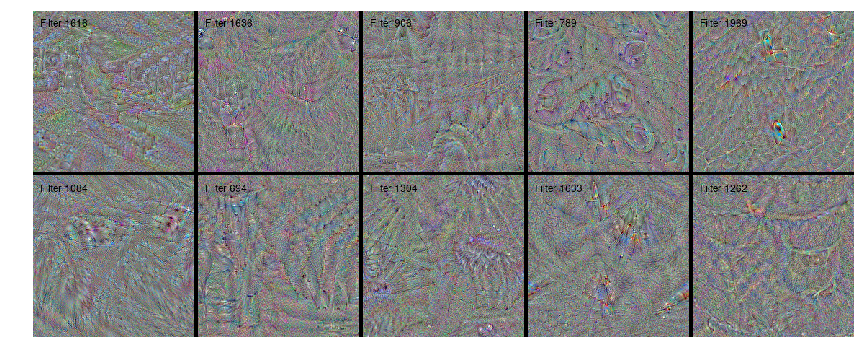

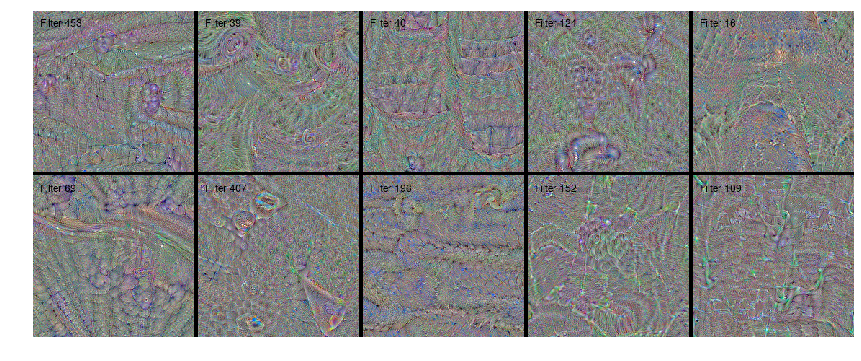

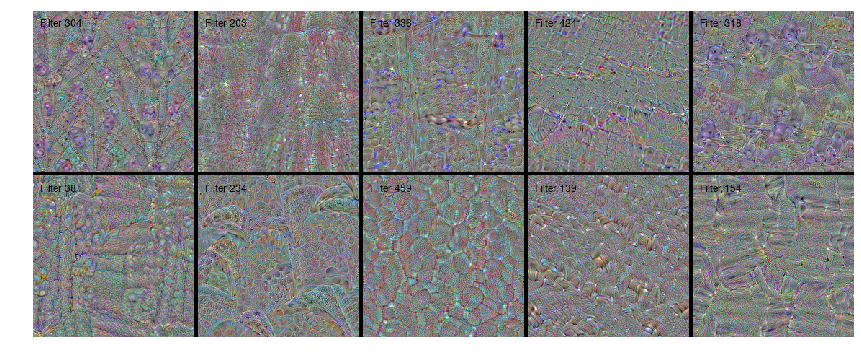

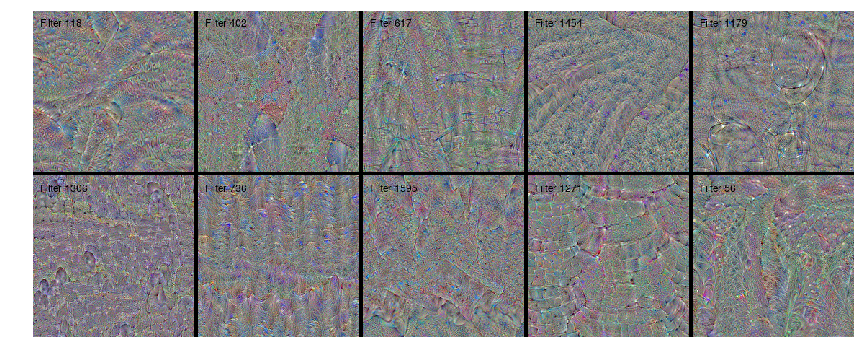

In [31]:
from vis.input_modifiers import Jitter
for layer_name in ['res5c_branch2c', 'res5c_branch2b', 'res5c_branch2a', 'res5b_branch2c']:
    layer_idx = utils.find_layer_idx(finetune_model, layer_name)

    # We need to select the same random filters in order to compare the results.
    filters = np.random.permutation(get_num_filters(finetune_model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        # We will jitter 5% relative to the image size.
        img = visualize_activation(finetune_model, layer_idx, filter_indices=idx, 
                                   tv_weight=0.,
                                   input_modifiers=[Jitter(0.05)])

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()